## COMP4211 Project

This notebook is developed based on [this Kaggle notebook](https://www.kaggle.com/code/gpiosenka/wonders-f1-score-98) and [this tutorial](https://usmanr149.github.io/urmlblog/cnn/2020/05/01/Salincy-Maps.html).

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/COMP4211_project/

Mounted at /content/drive/
/content/drive/MyDrive/COMP4211_project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import tensorflow.keras.applications as A
# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)
warnings.simplefilter("ignore")

In [7]:
# Prepare the dataframe that stores info about image data
df = pd.read_csv('wonders_data/wonders_of_world_images.csv')
df['filename'] = df['folder_name'] + "/" + df['filename']
df['class'] = df['folder_name']
df = df[['filename', 'class']]
df

,filename,class
0,burj_khalifa/0005487c0b.jpg,burj_khalifa
1,burj_khalifa/00d4a42317.jpg,burj_khalifa
2,burj_khalifa/01bbf1f63c.jpg,burj_khalifa
3,burj_khalifa/01f75e9545.jpg,burj_khalifa
4,burj_khalifa/020f2c752c.jpg,burj_khalifa
...,...,...
3841,venezuela_angel_falls/f8a9a1b84f.jpg,venezuela_angel_falls
3842,venezuela_angel_falls/fcc0dd88df.jpg,venezuela_angel_falls
3843,venezuela_angel_falls/fd5d26f3ab.jpg,venezuela_angel_falls
3844,venezuela_angel_falls/fdb5d988af.jpg,venezuela_angel_falls


In [8]:
# Train-Val-Test split
# Ratio is train: 0.8, val: 0.1, test: 0.1
train_df, rest = train_test_split(df, train_size=0.8, shuffle=True, random_state=4211, stratify=df['class']) 
val_df, test_df = train_test_split(rest, train_size=0.5, shuffle=True, random_state=4211, stratify=rest['class']) 

In [9]:
def get_dataset_info(df):

    print("Number of samples in each class:")
    info = {}
    class_names = list(df['class'].unique())
    for name in class_names:
        sub_df = df[df['class'] == name]
        info[name] = sub_df.count()[0]
    display(info)

get_dataset_info(train_df)

Number of samples in each class:


{'burj_khalifa': 312,
 'venezuela_angel_falls': 201,
 'stonehenge': 163,
 'pyramids_of_giza': 298,
 'taj_mahal': 126,
 'machu_pichu': 314,
 'great_wall_of_china': 314,
 'eiffel_tower': 313,
 'chichen_itza': 272,
 'statue_of_liberty': 190,
 'roman_colosseum': 315,
 'christ_the_reedemer': 258}

In [10]:
def prune_img(df):

    pruned = pd.DataFrame(columns=['filename', 'class'])
    class_names = list(df['class'].unique())
    for name in class_names:
        sub_df = df[df['class'] == name]
        if sub_df.shape[0] > 150:
            pruned = pd.concat([pruned, sub_df.iloc[:150]])
        else:
            pruned = pd.concat([pruned, sub_df])

    return pruned

train_df = prune_img(train_df)

In [11]:
# Check the training set after sampling
get_dataset_info(train_df)

Number of samples in each class:


{'burj_khalifa': 150,
 'venezuela_angel_falls': 150,
 'stonehenge': 150,
 'pyramids_of_giza': 150,
 'taj_mahal': 126,
 'machu_pichu': 150,
 'great_wall_of_china': 150,
 'eiffel_tower': 150,
 'chichen_itza': 150,
 'statue_of_liberty': 150,
 'roman_colosseum': 150,
 'christ_the_reedemer': 150}

In [12]:
root = '/content/drive/MyDrive/COMP4211_project/'
img_size = (200, 250)
batch_size = 32

# Prepare data, apply data augmentation on training data
train_data = ImageDataGenerator(horizontal_flip=True, 
                                rotation_range=10, 
                                width_shift_range=0.2, 
                                height_shift_range=0.2).flow_from_dataframe(train_df,
                                                                            directory=root+'wonders_data/Wonders of World/',
                                                                            x_col='filename', 
                                                                            y_col='class', 
                                                                            target_size=img_size,
                                                                            class_mode='categorical',
                                                                            color_mode='rgb',
                                                                            shuffle=True, 
                                                                            batch_size=batch_size)
                                
# Validation data
val_data = ImageDataGenerator().flow_from_dataframe(val_df, 
                                                    directory=root+'wonders_data/Wonders of World/',
                                                    x_col='filename', 
                                                    y_col='class', 
                                                    target_size=img_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb', 
                                                    shuffle=False, 
                                                    batch_size=batch_size)
# Test data
test_len = len(test_df)
test_batch_size = max([test_len // n for n in range(1, test_len+1) if test_len % n ==0 and test_len / n <= 40])
test_steps = test_len // test_batch_size
test_data = ImageDataGenerator().flow_from_dataframe(test_df, 
                                                     directory=root+'wonders_data/Wonders of World/',
                                                     x_col='filename', 
                                                     y_col='class', 
                                                     target_size=img_size,
                                                     class_mode='categorical', 
                                                     color_mode='rgb', 
                                                     shuffle=False, 
                                                     batch_size=test_batch_size)


Found 1776 validated image filenames belonging to 12 classes.
Found 385 validated image filenames belonging to 12 classes.
Found 385 validated image filenames belonging to 12 classes.


In [13]:
classes = list(train_data.class_indices.keys())
display(classes)

['burj_khalifa',
 'chichen_itza',
 'christ_the_reedemer',
 'eiffel_tower',
 'great_wall_of_china',
 'machu_pichu',
 'pyramids_of_giza',
 'roman_colosseum',
 'statue_of_liberty',
 'stonehenge',
 'taj_mahal',
 'venezuela_angel_falls']

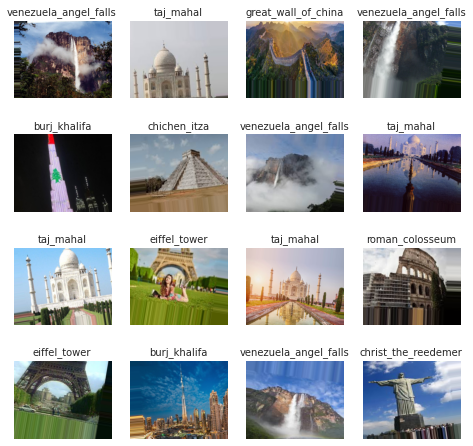

In [14]:
def show_image_samples(data):
    
    '''Takes an ImageDataGenerator and output a grid of plots'''
    class_names = list(data.class_indices.keys())

    images, labels = next(data)
    plt.figure(figsize=(8, 8))

    for i in range(16):        
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255       
        plt.imshow(image)
        class_name = class_names[labels[i].argmax()]
        plt.title(class_name, fontsize=10)
        plt.axis('off')

    plt.show()
    
show_image_samples(train_data)

In [15]:
class SimpleHead(tf.keras.layers.Layer):
    def __init__(self):
        super(SimpleHead, self).__init__()
        self.dense = Dense(12, activation='softmax')

    def call(self, inputs):
        return self.dense(inputs)

class ComplexHead(tf.keras.layers.Layer):
    def __init__(self):
        super(ComplexHead, self).__init__()
        self.bn1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)
        self.dense1 = Dense(1024, 
                            kernel_regularizer=regularizers.l2(l=0.016),
                            activity_regularizer=regularizers.l1(0.006),
                            bias_regularizer=regularizers.l1(0.006),
                            activation='relu')
        self.dropout1 = Dropout(rate=.3, seed=4211)
        self.dense2 = Dense(128, 
                            kernel_regularizer=regularizers.l2(l=0.016),
                            activity_regularizer=regularizers.l1(0.006),
                            bias_regularizer=regularizers.l1(0.006),
                            activation='relu')
        self.dropout2 = Dropout(rate=.45, seed=4211)
        self.dense3 = Dense(12, activation='softmax')

    def call(self, inputs, training):
        x = self.bn1(inputs)
        x = self.dense1(x)
        if training:
            x = self.dropout1(x)
        x = self.dense2(x)
        if training:
            x = self.dropout2(x)      
        output = self.dense3(x)
        return output

In [16]:
# Assemble backbone and head
def assemble_model(head, backbone, freeze_backbone=False):
    img_shape = (img_size[0], img_size[1], 3)
    
    backbone.trainable = not freeze_backbone
    x = backbone.output
    output = head(x)
    model = Model(inputs=backbone.input, outputs=output)

    return model

# Plot loss and accuracy curve in the training phase
def plot_loss_and_acc(history, backbone_name, head_complexity):
    #Plot the training and validation data

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    num_epoch = len(train_acc)
    epochs = []
    for i in range(num_epoch):
        epochs.append(i+1)   

    lowest_loss_epoch = np.argmin(val_loss)
    lowest_val_loss = val_loss[lowest_loss_epoch]

    highest_acc_epoch = np.argmax(val_acc)
    highest_val_acc = val_acc[highest_acc_epoch]

    loss_label = 'best epoch=' + str(lowest_loss_epoch + 1)
    acc_label = 'best epoch=' + str(highest_acc_epoch + 1)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle('Loss and Accuracy Curve (backbone: ' + backbone_name + ', head: ' + head_complexity + ')', fontsize=12)

    axes[0].plot(epochs, train_loss, 'r', label='training loss')
    axes[0].plot(epochs, val_loss, 'g', label='validation loss' )
    axes[0].scatter(lowest_loss_epoch+1, lowest_val_loss, s=50, c='blue', label=loss_label)
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot (epochs, train_acc, 'r', label= 'training accuracy')
    axes[1].plot (epochs, val_acc, 'g', label= 'validation accuracy')
    axes[1].scatter(highest_acc_epoch+1, highest_val_acc, s=50, c='blue', label=acc_label)
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.show()
    
# Main train function
def train_model(backbone, backbone_name, head_complexity, epochs, freeze_backbone=True, plot_loss=True):
    head = None
    if head_complexity == 'simple':
        head = SimpleHead()

    if head_complexity == 'complex':
        head = ComplexHead()

    # Assemble and compile model as specified
    model = assemble_model(head, backbone, freeze_backbone)

    print("=" * 40)

    model_property = backbone_name + " and a " + head_complexity + " head. Backbone frozen? " + str(freeze_backbone)
    print("Assembled", model_property)
    model.compile(Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    # Train
    history = model.fit(x=train_data,  
                        epochs=epochs,
                        verbose=1, 
                        validation_data=val_data, 
                        callbacks=callbacks,
                        validation_steps=None, 
                        shuffle=False,  
                        initial_epoch=0)
    
    if plot_loss:
        plot_loss_and_acc(history, backbone_name, head_complexity)

    return model

# Test model performance
def test_and_report(model, backbone_name, head_complexity, freeze_backbone):
    '''Given a trained model, return test accuracy, precision, recall, and F1-score'''
    print("-" * 40)

    model_property = backbone_name + " and a " + head_complexity + " head. Backbone frozen? " + str(freeze_backbone)
    print("Evaluating", model_property)

    predictions = model.predict(test_data, steps=test_steps, verbose=1)     # softmax probs (N, 12)
    # Turn the softmax probs into class labels
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.array(test_data.labels)

    # Compute test accuracy
    num_incorrect = np.sum(y_pred != y_true)
    acc = 1 - num_incorrect / y_pred.shape[0]
    print("Test accuracy:", acc,)
 
    # Produce the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 5))
    sns.heatmap(conf_matrix, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(12)+.5, classes, rotation=90)
    plt.yticks(np.arange(12)+.5, classes, rotation=0)
    plt.xlabel("prediction")
    plt.ylabel("ground truth")
    plt.title("Confusion Matrix of " + model_property)
    plt.show()



In [17]:
# Global training configs
img_shape = (img_size[0], img_size[1], 3)
lr = 0.001
epochs = 5
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1, restore_best_weights=True)
callbacks = [lr_decay, early_stopping]

Assembled EfficientNetB3 and a simple head. Backbone freezed? False
Epoch 1/5
56/56 [==============================] - 64s 903ms/step - loss: 1.4133 - accuracy: 0.7387 - val_loss: 0.5720 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 50s 882ms/step - loss: 0.2366 - accuracy: 0.9358 - val_loss: 0.2743 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 48s 860ms/step - loss: 0.1240 - accuracy: 0.9707 - val_loss: 0.2362 - val_accuracy: 0.9532 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 50s 888ms/step - loss: 0.1468 - accuracy: 0.9634 - val_loss: 0.5809 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 48s 856ms/step - loss: 0.1222 - accuracy: 0.9657 - val_loss: 0.1959 - val_accuracy: 0.9506 - lr: 0.0010


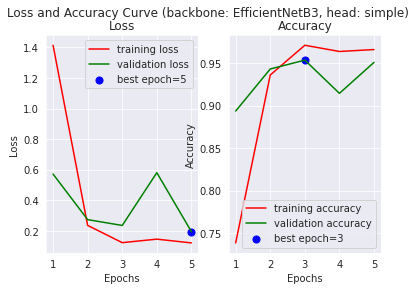

----------------------------------------
Evaluating EfficientNetB3 and a simple head. Backbone freezed? False
11/11 [==============================] - 6s 290ms/step
Test accuracy: 0.9428571428571428


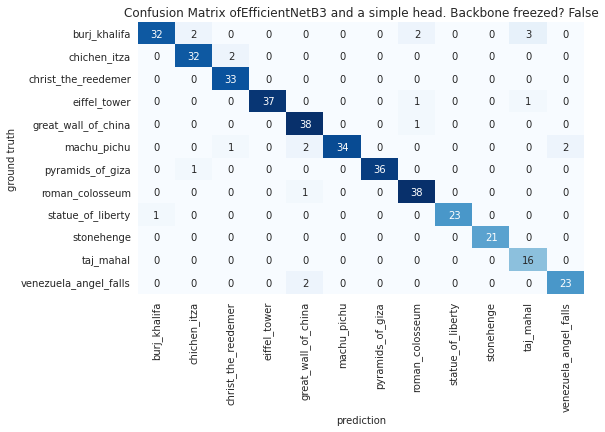

In [ ]:
# Dev code
backbone = A.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
backbone_name = 'EfficientNetB3'
head_complexity = 'simple'
freeze_backbone = False

model = train_model(backbone, backbone_name, head_complexity, epochs, freeze_backbone, plot_loss=True)
test_and_report(model, backbone_name, head_complexity, freeze_backbone)

43941136/43941136 [==============================] - 2s 0us/step
Assembled ResNet50 and a simple head. Backbone frozen? True
Epoch 1/5
56/56 [==============================] - 808s 14s/step - loss: 4.3299 - accuracy: 0.4825 - val_loss: 1.6486 - val_accuracy: 0.7091 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 42s 748ms/step - loss: 1.3027 - accuracy: 0.7742 - val_loss: 1.1759 - val_accuracy: 0.7948 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 42s 745ms/step - loss: 0.7446 - accuracy: 0.8530 - val_loss: 0.8496 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 44s 785ms/step - loss: 0.7344 - accuracy: 0.8615 - val_loss: 0.7176 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 55s 989ms/step - loss: 0.5618 - accuracy: 0.8829 - val_loss: 0.5544 - val_accuracy: 0.8935 - lr: 0.0010


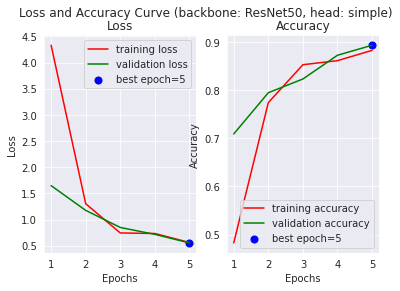

----------------------------------------
Evaluating ResNet50 and a simple head. Backbone frozen? True
11/11 [==============================] - 136s 13s/step
Test accuracy: 0.9064935064935065


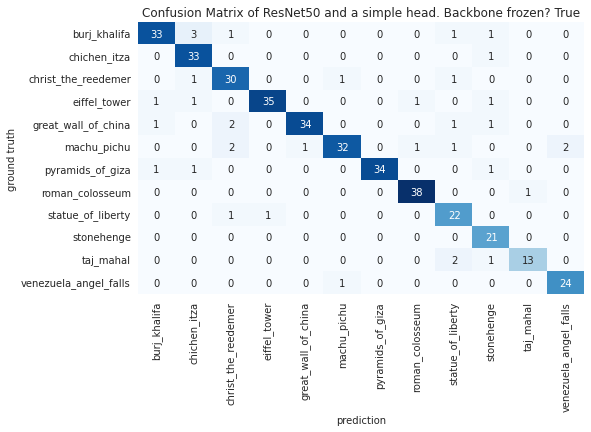

Assembled ResNet50 and a simple head. Backbone frozen? False
Epoch 1/5
56/56 [==============================] - 58s 890ms/step - loss: 5.9100 - accuracy: 0.5377 - val_loss: 116011.9609 - val_accuracy: 0.0416 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 48s 851ms/step - loss: 2.9538 - accuracy: 0.6661 - val_loss: 6.7848 - val_accuracy: 0.1273 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 48s 853ms/step - loss: 2.9570 - accuracy: 0.6481 - val_loss: 289.7763 - val_accuracy: 0.0675 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - ETA: 0s - loss: 1.6572 - accuracy: 0.7297
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 [==============================] - 48s 849ms/step - loss: 1.6572 - accuracy: 0.7297 - val_loss: 120.0775 - val_accuracy: 0.1169 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 49s 873ms/step - loss: 1.0113 - accuracy: 0.7866 - val_loss: 3.7115 - val_accuracy: 0.7299 - lr: 5.0

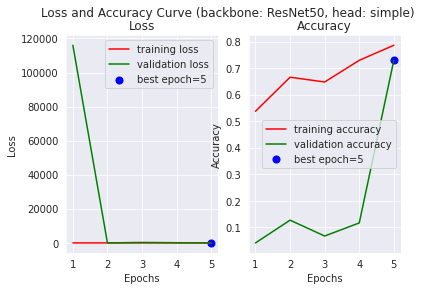

----------------------------------------
Evaluating ResNet50 and a simple head. Backbone frozen? False
11/11 [==============================] - 5s 341ms/step
Test accuracy: 0.7350649350649351


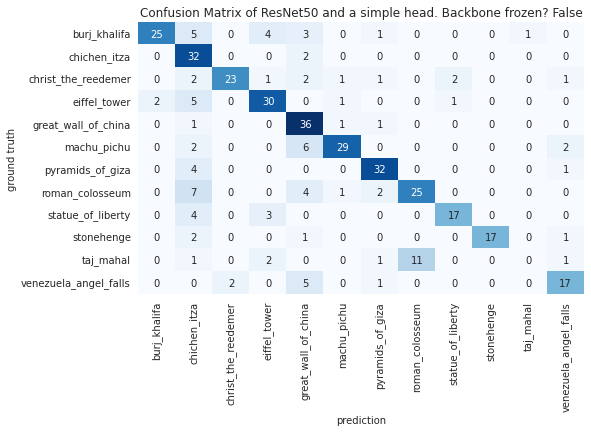

Assembled ResNet50 and a complex head. Backbone frozen? True
Epoch 1/5
56/56 [==============================] - 49s 802ms/step - loss: 23.3094 - accuracy: 0.5383 - val_loss: 16.1463 - val_accuracy: 0.7455 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 43s 776ms/step - loss: 11.3386 - accuracy: 0.7050 - val_loss: 8.0901 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 44s 786ms/step - loss: 6.0860 - accuracy: 0.7404 - val_loss: 4.4290 - val_accuracy: 0.7662 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 44s 795ms/step - loss: 3.7863 - accuracy: 0.7579 - val_loss: 3.0772 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 43s 776ms/step - loss: 2.7669 - accuracy: 0.7827 - val_loss: 2.3952 - val_accuracy: 0.7662 - lr: 0.0010


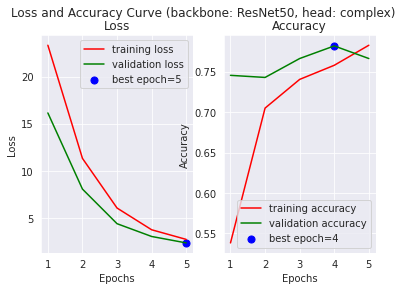

----------------------------------------
Evaluating ResNet50 and a complex head. Backbone frozen? True
11/11 [==============================] - 5s 341ms/step
Test accuracy: 0.8077922077922077


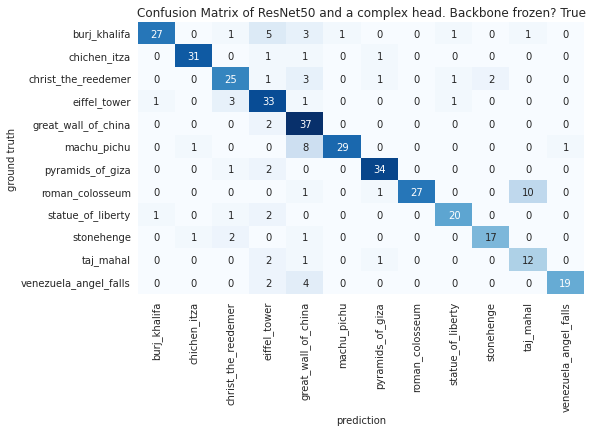

Assembled ResNet50 and a complex head. Backbone frozen? False
Epoch 1/5
56/56 [==============================] - 54s 851ms/step - loss: 24.2141 - accuracy: 0.3193 - val_loss: 42203.1094 - val_accuracy: 0.0883 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 47s 835ms/step - loss: 12.1701 - accuracy: 0.4257 - val_loss: 2380.9963 - val_accuracy: 0.0753 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 48s 860ms/step - loss: 6.3978 - accuracy: 0.5552 - val_loss: 243.0063 - val_accuracy: 0.1455 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 47s 841ms/step - loss: 4.1057 - accuracy: 0.5445 - val_loss: 6.8672 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 47s 844ms/step - loss: 3.1813 - accuracy: 0.6025 - val_loss: 6.1792 - val_accuracy: 0.3584 - lr: 0.0010


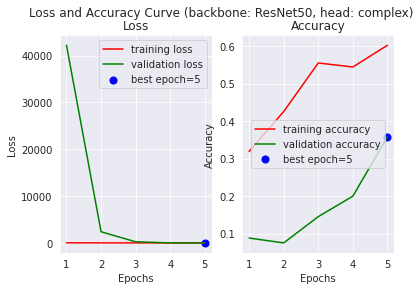

----------------------------------------
Evaluating ResNet50 and a complex head. Backbone frozen? False
11/11 [==============================] - 5s 343ms/step
Test accuracy: 0.33246753246753247


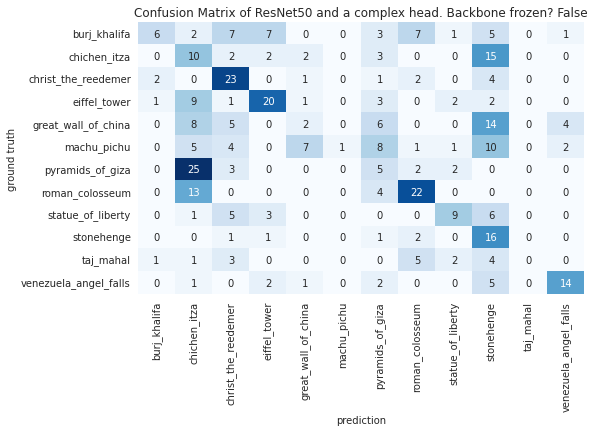

Assembled VGG16 and a simple head. Backbone frozen? True
Epoch 1/5
56/56 [==============================] - 50s 836ms/step - loss: 37.2543 - accuracy: 0.2297 - val_loss: 22.2346 - val_accuracy: 0.4468 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 44s 789ms/step - loss: 14.4693 - accuracy: 0.5450 - val_loss: 10.9851 - val_accuracy: 0.6390 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 45s 796ms/step - loss: 8.8803 - accuracy: 0.6565 - val_loss: 7.5561 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 44s 787ms/step - loss: 6.1733 - accuracy: 0.7517 - val_loss: 6.3426 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 45s 806ms/step - loss: 5.1126 - accuracy: 0.7748 - val_loss: 4.6255 - val_accuracy: 0.8156 - lr: 0.0010


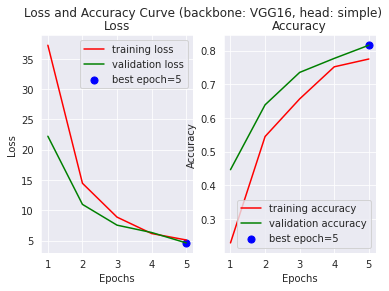

----------------------------------------
Evaluating VGG16 and a simple head. Backbone frozen? True
11/11 [==============================] - 7s 332ms/step
Test accuracy: 0.825974025974026


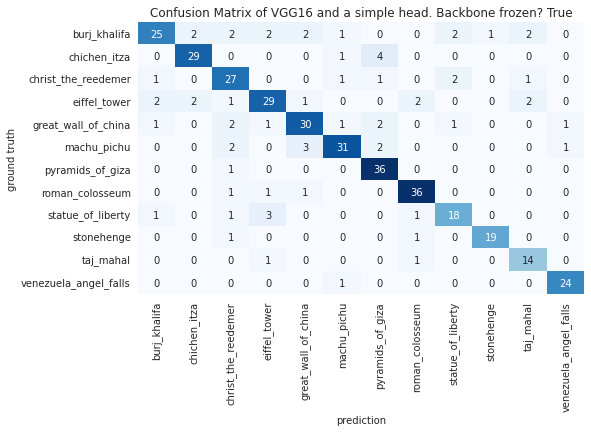

Assembled VGG16 and a simple head. Backbone frozen? False
Epoch 1/5
56/56 [==============================] - 54s 887ms/step - loss: 28.8404 - accuracy: 0.0805 - val_loss: 2.4728 - val_accuracy: 0.0649 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 48s 844ms/step - loss: 2.4919 - accuracy: 0.0923 - val_loss: 2.4712 - val_accuracy: 0.1169 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 48s 848ms/step - loss: 2.4909 - accuracy: 0.0923 - val_loss: 2.6307 - val_accuracy: 0.1013 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 49s 873ms/step - loss: 2.4939 - accuracy: 0.0952 - val_loss: 2.4546 - val_accuracy: 0.0987 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 48s 856ms/step - loss: 2.4761 - accuracy: 0.0918 - val_loss: 2.4678 - val_accuracy: 0.1247 - lr: 0.0010


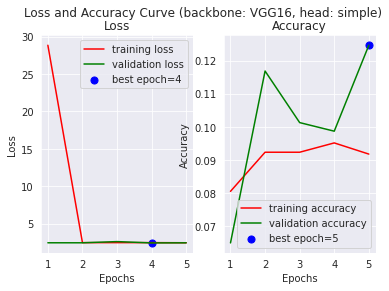

----------------------------------------
Evaluating VGG16 and a simple head. Backbone frozen? False
11/11 [==============================] - 4s 358ms/step
Test accuracy: 0.1298701298701299


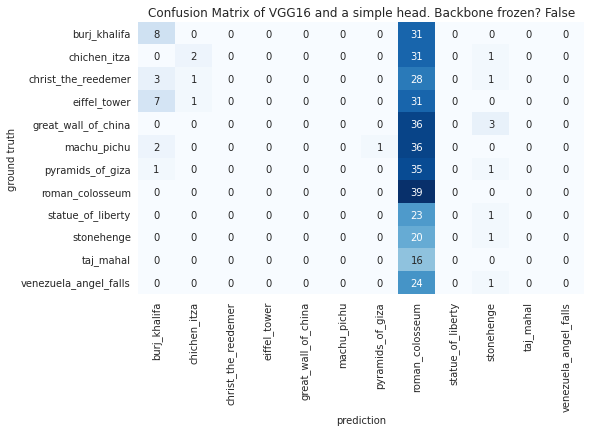

Assembled VGG16 and a complex head. Backbone frozen? True
Epoch 1/5
56/56 [==============================] - 45s 788ms/step - loss: 7.6336 - accuracy: 0.1092 - val_loss: 3.2301 - val_accuracy: 0.1532 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 44s 785ms/step - loss: 2.7504 - accuracy: 0.1154 - val_loss: 2.5503 - val_accuracy: 0.1169 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 44s 785ms/step - loss: 2.5167 - accuracy: 0.0873 - val_loss: 2.4954 - val_accuracy: 0.1091 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 44s 778ms/step - loss: 2.4937 - accuracy: 0.0929 - val_loss: 2.4873 - val_accuracy: 0.1117 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 45s 796ms/step - loss: 2.4886 - accuracy: 0.0940 - val_loss: 2.4810 - val_accuracy: 0.1091 - lr: 0.0010


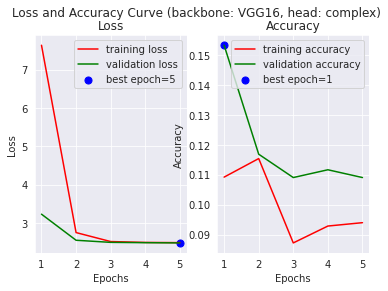

----------------------------------------
Evaluating VGG16 and a complex head. Backbone frozen? True
11/11 [==============================] - 4s 353ms/step
Test accuracy: 0.11168831168831173


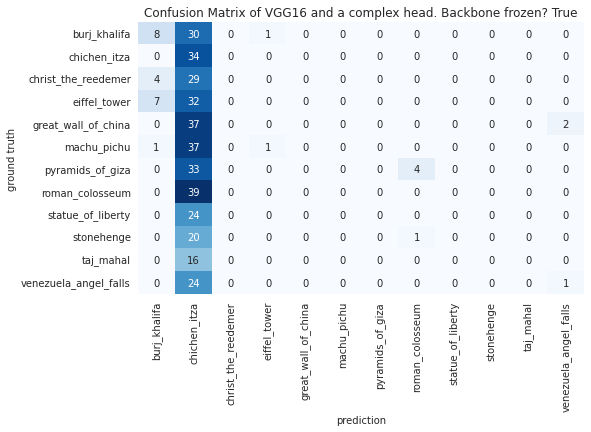

Assembled VGG16 and a complex head. Backbone frozen? False
Epoch 1/5
56/56 [==============================] - 49s 854ms/step - loss: 7.2636 - accuracy: 0.0732 - val_loss: 15.5138 - val_accuracy: 0.0519 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 48s 846ms/step - loss: 2.5861 - accuracy: 0.0794 - val_loss: 2.4930 - val_accuracy: 0.0623 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 49s 862ms/step - loss: 2.4884 - accuracy: 0.0805 - val_loss: 2.4865 - val_accuracy: 0.0623 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 48s 848ms/step - loss: 2.4867 - accuracy: 0.0670 - val_loss: 2.4846 - val_accuracy: 0.0519 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 47s 845ms/step - loss: 2.4861 - accuracy: 0.0805 - val_loss: 2.4841 - val_accuracy: 0.0649 - lr: 0.0010


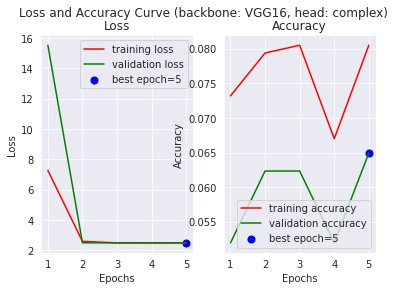

----------------------------------------
Evaluating VGG16 and a complex head. Backbone frozen? False
11/11 [==============================] - 4s 356ms/step
Test accuracy: 0.06493506493506496


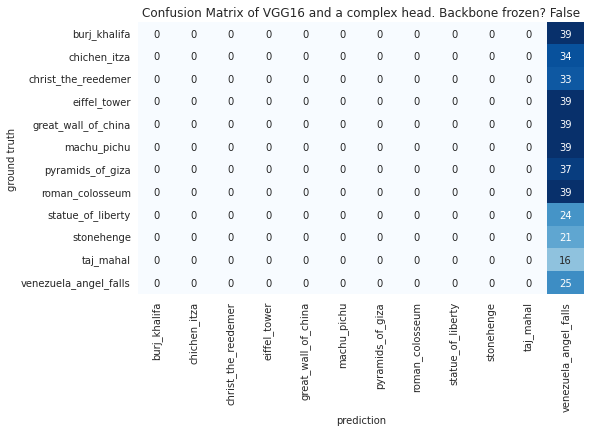

Assembled InceptionV3 and a simple head. Backbone frozen? True
Epoch 1/5
56/56 [==============================] - 51s 806ms/step - loss: 44.4015 - accuracy: 0.1441 - val_loss: 26.8671 - val_accuracy: 0.2182 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 43s 769ms/step - loss: 28.9698 - accuracy: 0.1903 - val_loss: 22.6661 - val_accuracy: 0.2649 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 42s 751ms/step - loss: 31.2777 - accuracy: 0.2005 - val_loss: 23.7418 - val_accuracy: 0.2779 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - ETA: 0s - loss: 26.0491 - accuracy: 0.2404
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 [==============================] - 43s 758ms/step - loss: 26.0491 - accuracy: 0.2404 - val_loss: 24.3511 - val_accuracy: 0.2519 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 44s 783ms/step - loss: 19.3615 - accuracy: 0.2872 - val_loss: 19.4551 - val_accuracy: 0.3117 - lr:

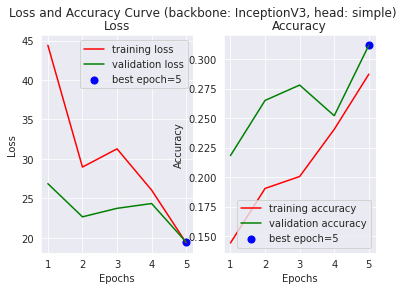

----------------------------------------
Evaluating InceptionV3 and a simple head. Backbone frozen? True
11/11 [==============================] - 6s 307ms/step
Test accuracy: 0.2961038961038961


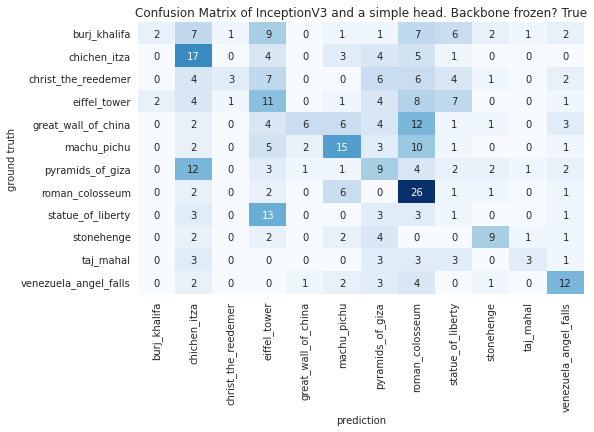

Assembled InceptionV3 and a simple head. Backbone frozen? False
Epoch 1/5
56/56 [==============================] - 55s 831ms/step - loss: 1.5010 - accuracy: 0.6425 - val_loss: 28.2209 - val_accuracy: 0.0883 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 44s 790ms/step - loss: 0.8441 - accuracy: 0.7765 - val_loss: 7.5727 - val_accuracy: 0.2208 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 45s 792ms/step - loss: 0.4853 - accuracy: 0.8581 - val_loss: 5.8263 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 44s 788ms/step - loss: 0.2866 - accuracy: 0.9229 - val_loss: 0.7516 - val_accuracy: 0.8104 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 44s 788ms/step - loss: 0.2538 - accuracy: 0.9206 - val_loss: 0.6383 - val_accuracy: 0.8390 - lr: 0.0010


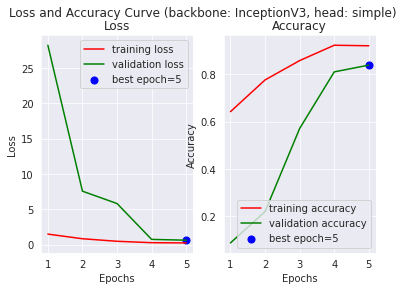

----------------------------------------
Evaluating InceptionV3 and a simple head. Backbone frozen? False
11/11 [==============================] - 5s 325ms/step
Test accuracy: 0.8233766233766233


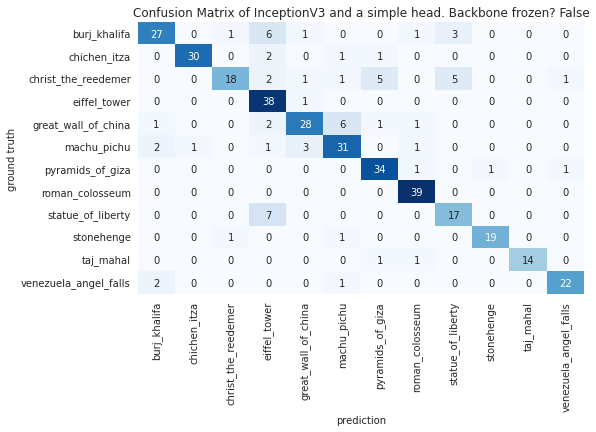

Assembled InceptionV3 and a complex head. Backbone frozen? True
Epoch 1/5
56/56 [==============================] - 48s 787ms/step - loss: 21.7786 - accuracy: 0.7613 - val_loss: 12.6461 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 42s 759ms/step - loss: 8.3683 - accuracy: 0.8767 - val_loss: 5.0824 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 42s 748ms/step - loss: 3.7299 - accuracy: 0.8750 - val_loss: 2.7032 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 42s 751ms/step - loss: 2.1846 - accuracy: 0.8891 - val_loss: 1.8840 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 42s 747ms/step - loss: 1.6838 - accuracy: 0.8829 - val_loss: 1.4957 - val_accuracy: 0.8805 - lr: 0.0010


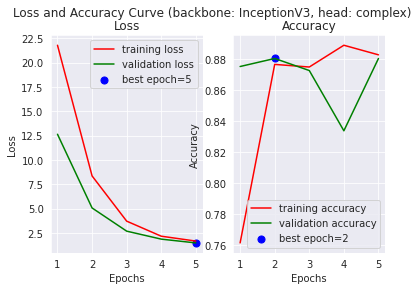

----------------------------------------
Evaluating InceptionV3 and a complex head. Backbone frozen? True
11/11 [==============================] - 5s 323ms/step
Test accuracy: 0.8779220779220779


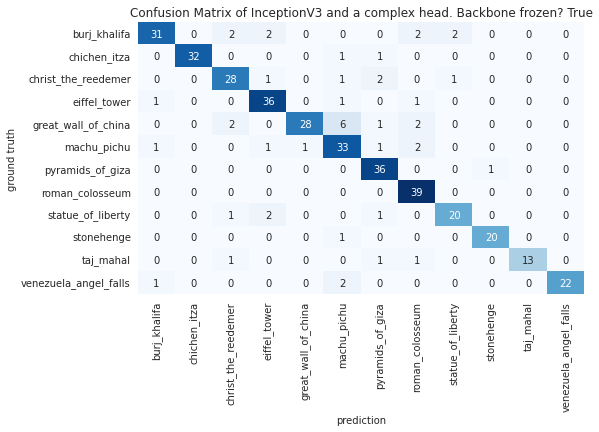

Assembled InceptionV3 and a complex head. Backbone frozen? False
Epoch 1/5
56/56 [==============================] - 54s 837ms/step - loss: 18.3421 - accuracy: 0.6368 - val_loss: 1620.8224 - val_accuracy: 0.1117 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 44s 788ms/step - loss: 6.6475 - accuracy: 0.6385 - val_loss: 341.9319 - val_accuracy: 0.1065 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 44s 784ms/step - loss: 3.2646 - accuracy: 0.7556 - val_loss: 207.5597 - val_accuracy: 0.3688 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 45s 804ms/step - loss: 2.0794 - accuracy: 0.8243 - val_loss: 2.2857 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 46s 825ms/step - loss: 1.7614 - accuracy: 0.7911 - val_loss: 2.6547 - val_accuracy: 0.3948 - lr: 0.0010


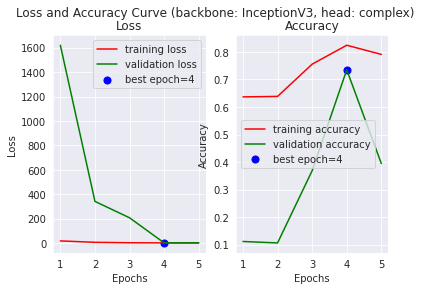

----------------------------------------
Evaluating InceptionV3 and a complex head. Backbone frozen? False
11/11 [==============================] - 5s 336ms/step
Test accuracy: 0.4025974025974026


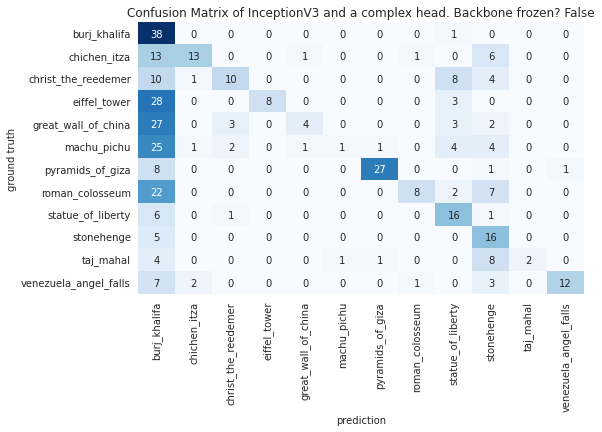

Assembled EfficientNetB3 and a simple head. Backbone frozen? True
Epoch 1/5
56/56 [==============================] - 57s 832ms/step - loss: 3.0394 - accuracy: 0.4538 - val_loss: 1.0995 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 44s 782ms/step - loss: 1.0736 - accuracy: 0.7410 - val_loss: 0.5751 - val_accuracy: 0.8416 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 44s 781ms/step - loss: 0.7748 - accuracy: 0.7979 - val_loss: 0.4235 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 43s 768ms/step - loss: 0.5576 - accuracy: 0.8378 - val_loss: 0.3682 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 42s 761ms/step - loss: 0.4511 - accuracy: 0.8581 - val_loss: 0.3906 - val_accuracy: 0.9065 - lr: 0.0010


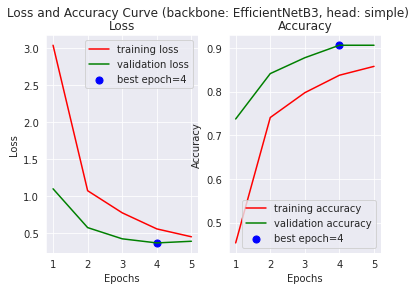

----------------------------------------
Evaluating EfficientNetB3 and a simple head. Backbone frozen? True
11/11 [==============================] - 7s 319ms/step
Test accuracy: 0.9090909090909091


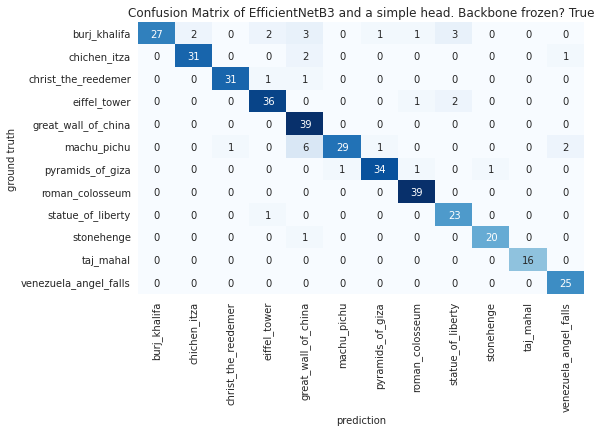

Assembled EfficientNetB3 and a simple head. Backbone frozen? False
Epoch 1/5
56/56 [==============================] - 73s 994ms/step - loss: 1.3355 - accuracy: 0.7590 - val_loss: 1.3202 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 52s 920ms/step - loss: 0.2215 - accuracy: 0.9398 - val_loss: 0.8879 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 53s 937ms/step - loss: 0.1465 - accuracy: 0.9600 - val_loss: 0.3955 - val_accuracy: 0.9299 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 52s 926ms/step - loss: 0.2783 - accuracy: 0.9510 - val_loss: 1.1385 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 53s 945ms/step - loss: 0.0893 - accuracy: 0.9792 - val_loss: 0.2037 - val_accuracy: 0.9532 - lr: 0.0010


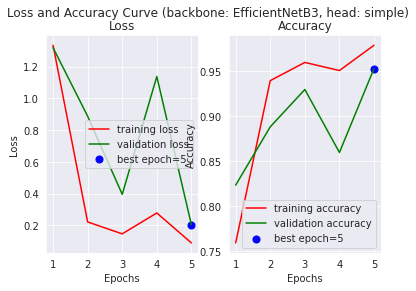

----------------------------------------
Evaluating EfficientNetB3 and a simple head. Backbone frozen? False
11/11 [==============================] - 6s 337ms/step
Test accuracy: 0.9662337662337662


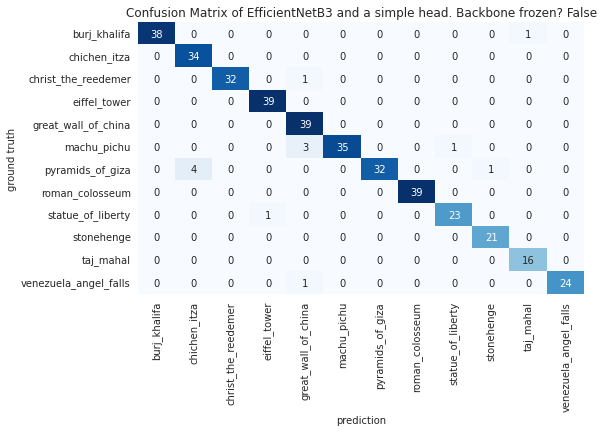

Assembled EfficientNetB3 and a complex head. Backbone frozen? True
Epoch 1/5
56/56 [==============================] - 56s 820ms/step - loss: 18.7207 - accuracy: 0.8958 - val_loss: 10.1059 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 43s 768ms/step - loss: 5.8921 - accuracy: 0.9820 - val_loss: 3.0919 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 44s 790ms/step - loss: 2.1367 - accuracy: 0.9859 - val_loss: 1.4029 - val_accuracy: 0.9740 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 43s 761ms/step - loss: 1.1711 - accuracy: 0.9831 - val_loss: 0.9184 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 43s 765ms/step - loss: 0.9127 - accuracy: 0.9747 - val_loss: 0.8586 - val_accuracy: 0.9610 - lr: 0.0010


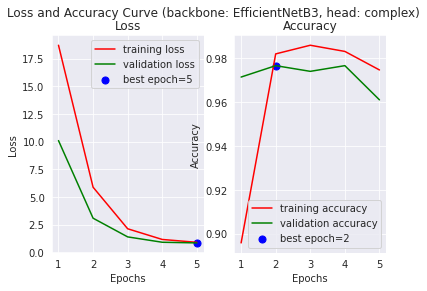

----------------------------------------
Evaluating EfficientNetB3 and a complex head. Backbone frozen? True
11/11 [==============================] - 6s 338ms/step
Test accuracy: 0.9766233766233766


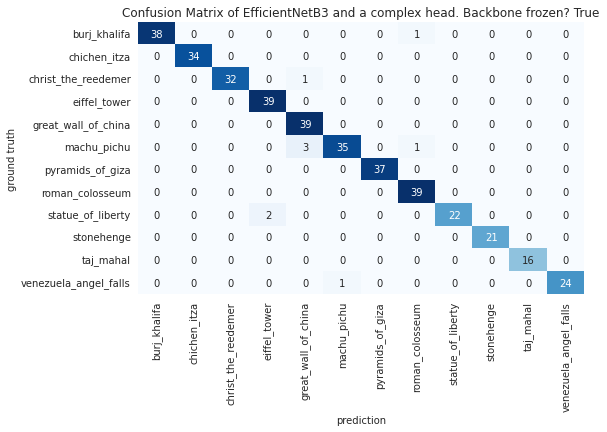

Assembled EfficientNetB3 and a complex head. Backbone frozen? False
Epoch 1/5
56/56 [==============================] - 71s 1s/step - loss: 18.9352 - accuracy: 0.8688 - val_loss: 13.0172 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 52s 923ms/step - loss: 7.3569 - accuracy: 0.9043 - val_loss: 9.3948 - val_accuracy: 0.5636 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 52s 925ms/step - loss: 3.1771 - accuracy: 0.9189 - val_loss: 2.9260 - val_accuracy: 0.9039 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 54s 964ms/step - loss: 1.6323 - accuracy: 0.9555 - val_loss: 1.6862 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 52s 930ms/step - loss: 1.0818 - accuracy: 0.9690 - val_loss: 0.8680 - val_accuracy: 0.9740 - lr: 0.0010


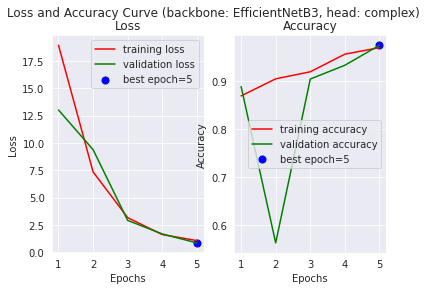

----------------------------------------
Evaluating EfficientNetB3 and a complex head. Backbone frozen? False
11/11 [==============================] - 6s 344ms/step
Test accuracy: 0.9298701298701298


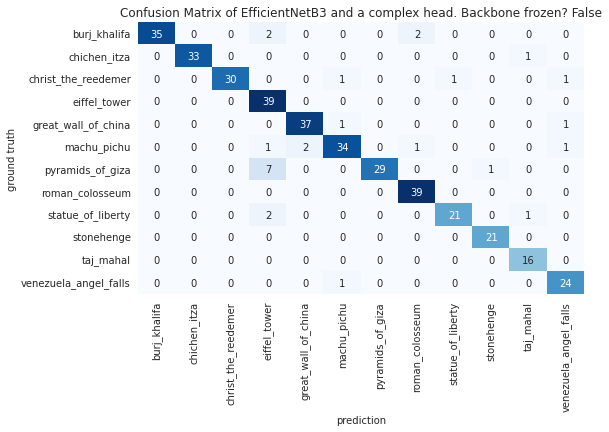

In [14]:
# Explore different backbones and configurations
backbones = [(A.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'), 'ResNet50'),
             (A.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'), 'VGG16'),
             (A.InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'), 'InceptionV3'),
             (A.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'), 'EfficientNetB3')]

heads = ['simple', 'complex']

freeze_backbone_options = [True, False]

grid = [(backbone, backbone_name, head_complexity, freeze_backbone) 
        for backbone, backbone_name in backbones 
        for head_complexity in heads
        for freeze_backbone in freeze_backbone_options]

for (backbone, backbone_name, head_complexity, freeze_backbone) in grid:
    model = train_model(backbone, backbone_name, head_complexity, epochs, freeze_backbone, plot_loss=True)
    test_and_report(model, backbone_name, head_complexity, freeze_backbone)


Assembled ResNet50 and a simple head. Backbone frozen? True
Epoch 1/10
56/56 [==============================] - 53s 810ms/step - loss: 4.6633 - accuracy: 0.4561 - val_loss: 1.7316 - val_accuracy: 0.7169 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - 45s 801ms/step - loss: 1.3423 - accuracy: 0.7669 - val_loss: 1.1103 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - 43s 758ms/step - loss: 0.9173 - accuracy: 0.8333 - val_loss: 0.9880 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - 44s 776ms/step - loss: 0.7084 - accuracy: 0.8626 - val_loss: 0.7962 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - 43s 763ms/step - loss: 0.5023 - accuracy: 0.8975 - val_loss: 0.7978 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - 43s 770ms/step - loss: 0.3820 - accuracy: 0.9088 - val_loss: 0.5574 - val_accuracy: 0.8987 - lr: 0.0010
Epoc

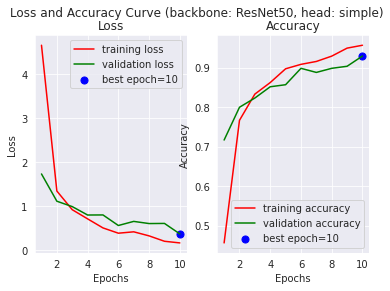

----------------------------------------
Evaluating EfficientNetB3 and a complex head. Backbone frozen? False
11/11 [==============================] - 5s 335ms/step
Test accuracy: 0.9194805194805195


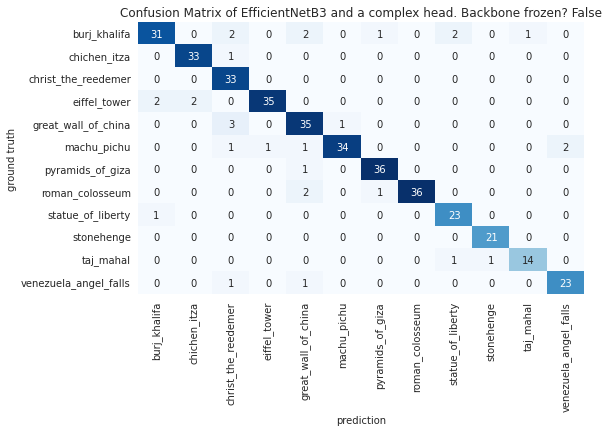

In [23]:
backbone = A.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = train_model(backbone, backbone_name='ResNet50', head_complexity='simple', epochs=10, freeze_backbone=True, plot_loss=True)
test_and_report(model, backbone_name, head_complexity, freeze_backbone)

Assembled ResNet50 and a simple head. Backbone frozen? False
Epoch 1/10
56/56 [==============================] - 56s 882ms/step - loss: 5.9621 - accuracy: 0.5473 - val_loss: 447.7295 - val_accuracy: 0.1065 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - 47s 843ms/step - loss: 2.8158 - accuracy: 0.6757 - val_loss: 6962.7720 - val_accuracy: 0.1143 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 2.3757 - accuracy: 0.6988
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 [==============================] - 47s 841ms/step - loss: 2.3757 - accuracy: 0.6988 - val_loss: 3479.2571 - val_accuracy: 0.0623 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - 49s 867ms/step - loss: 0.8714 - accuracy: 0.8046 - val_loss: 8.9947 - val_accuracy: 0.5273 - lr: 5.0000e-04
Epoch 5/10
56/56 [==============================] - 47s 835ms/step - loss: 0.5264 - accuracy: 0.8733 - val_loss: 3.0043 - val_accuracy: 0.7429 -

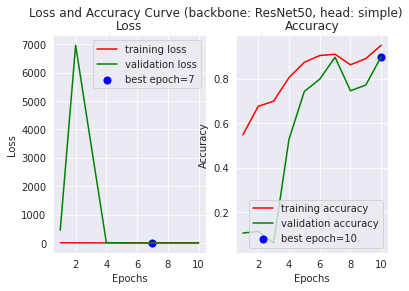

----------------------------------------
Evaluating EfficientNetB3 and a complex head. Backbone frozen? False
11/11 [==============================] - 5s 332ms/step
Test accuracy: 0.9012987012987013


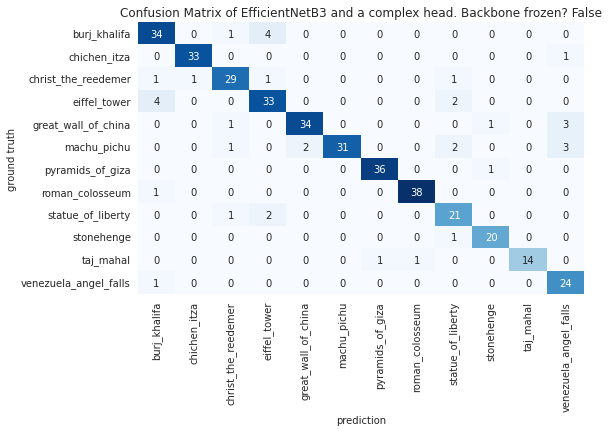

In [24]:
backbone = A.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = train_model(backbone, backbone_name='ResNet50', head_complexity='simple', epochs=10, freeze_backbone=False, plot_loss=True)
test_and_report(model, backbone_name, head_complexity, freeze_backbone)

In [31]:
backbone = A.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
sm_model = train_model(backbone, backbone_name='ResNet50', head_complexity='simple', epochs=5, freeze_backbone=True, plot_loss=False)

Assembled ResNet50 and a simple head. Backbone frozen? True
Epoch 1/5
56/56 [==============================] - 44s 738ms/step - loss: 4.7364 - accuracy: 0.4617 - val_loss: 1.4824 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 40s 707ms/step - loss: 1.3375 - accuracy: 0.7663 - val_loss: 1.1623 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 40s 717ms/step - loss: 0.8774 - accuracy: 0.8300 - val_loss: 1.0471 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 40s 705ms/step - loss: 0.6774 - accuracy: 0.8570 - val_loss: 0.7321 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 41s 734ms/step - loss: 0.4796 - accuracy: 0.9037 - val_loss: 0.6968 - val_accuracy: 0.8727 - lr: 0.0010


In [36]:
def saliancy_map(img_path, model):
    raw_img = keras.preprocessing.image.load_img(img_path, target_size=(200, 250))

    img = keras.preprocessing.image.img_to_array(raw_img)
    img = img.reshape((1, *img.shape))

    y_pred = model.predict(img)
    print("Predicted label:", classes[y_pred.argmax()])

    images = tf.Variable(img, dtype=float)
    with tf.GradientTape() as tape:
        pred = model(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]
        
    grads = tape.gradient(loss, images)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    axes[0].imshow(raw_img)
    i = axes[1].imshow(grad_eval, cmap="jet", alpha=0.8)
    fig.colorbar(i)

1/1 [==============================] - 0s 45ms/step
Predicted label: christ_the_reedemer


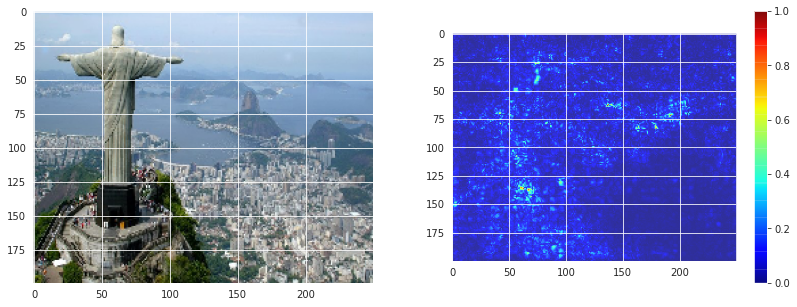

In [48]:
saliancy_map('wonders_data/Wonders of World/christ_the_reedemer/1acf33bd82.jpg', sm_model)

1/1 [==============================] - 0s 104ms/step
Predicted label: great_wall_of_china


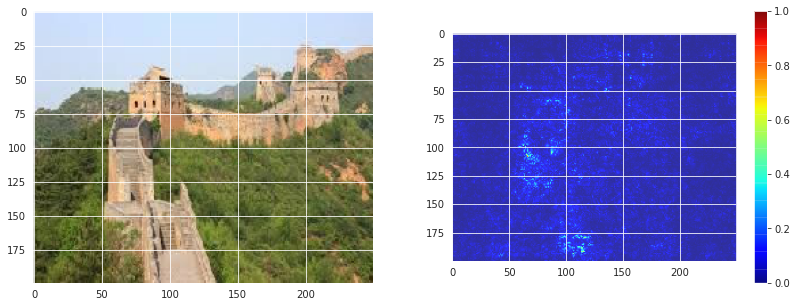

In [56]:
saliancy_map('wonders_data/Wonders of World/great_wall_of_china/1fd912db0f.jpg', sm_model)